In [1]:
import numpy as np
import matplotlib.pylab as plt
import glob
from matplotlib.ticker import ScalarFormatter
import ast
import h5py
from lattice_translocators import LEFTranslocator, LEFTranslocatorDynamicBoundary
from funcs import *
import cooltools
import cooltools.lib.plotting
%matplotlib inline

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/cooltools/lib/numutils.py:11: FutureWarning: The `cooler.tools` module is deprecated in v0.9 and will be removed in v0.10. Use `cooler.parallel` instead.
  from ._numutils import (
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/cooltools/api/expected.py:14: FutureWarning: The `cooler.tools` module is deprecated in v0.9 and will be removed in v0.10. Use `cooler.parallel` instead.
  from cooler.tools import partition


In [4]:
import dynamic_extrusion_boundaries.dynamic_extrusion_boundaries

ModuleNotFoundError: No module named 'dynamic_extrusion_boundaries'

### params

In [2]:
paramdict_CTCF = {
    'CTCF_facestall': [1, 1],
    'CTCF_backstall': [0., 0.],
    'CTCF_lifetime': [1, 1],
    'CTCF_offtime': [0.1, 0.1],
    'LEF_lifetime': [500, 500],
    'LEF_stalled_lifetime': [500, 500],
    'LEF_birth': [0.1, 0.1],
    'LEF_pause': [0.9, 0.9],
    'LEF_separation': 300,
    'sites_per_monomer': 10,
    'monomers_per_replica': 1000,
    'number_of_replica': 1,
    'steps': 200,
    'velocity_multiplier': 1
}

In [3]:
monomers_per_replica = paramdict_CTCF['monomers_per_replica'] 
sites_per_monomer = paramdict_CTCF['sites_per_monomer']
sites_per_replica = monomers_per_replica*sites_per_monomer
monomer_types = np.zeros(monomers_per_replica, dtype=int)
site_types = np.repeat(monomer_types, sites_per_monomer)
#print(len(site_types))

# Let's make some strong and weak CTCF regions
typedict = {'strong_CTCF':1, 'weak_CTCF':0}
site_types[15000:15300] = typedict['strong_CTCF']
site_types[:15000] = site_types[15300:] = typedict['weak_CTCF']


# LEF/CTCF properties in type A monomers may be obtained from the paramdict as follows
LEF_lifetime = paramdict_CTCF['LEF_lifetime']
CTCF_facestall = paramdict_CTCF['CTCF_facestall']
CTCF_offtime = paramdict_CTCF['CTCF_offtime']
#print(CTCF_offtime[typedict['strong_CTCF']], CTCF_offtime[typedict['weak_CTCF']])

# Create some CTCF boundary sites
ctcfrightlist = [314, 579, 1195, 3717, 3772, 3921, 4451, 5193, 5723, 6302, 6574, 6779, 7000, 9232, 9310, 9861]
ctcfleftlist = [495, 865, 1404, 2164, 3143, 3615, 3971, 4069, 4480, 4938, 5300, 5587, 6401, 7725, 8764, 9619]
CTCF_right_positions = np.array(ctcfrightlist)
CTCF_left_positions = np.array(ctcfleftlist)

In [4]:
translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                                 site_types,
                                                 CTCF_left_positions,
                                                 CTCF_right_positions, 
                                                 **paramdict_CTCF)

In [5]:
ctcfrights = np.array(translocator.stallProbRight)
ctcflefts = np.array(translocator.stallProbLeft)
print(len(ctcfrights))
ctcfrights[ctcfrightlist]

10000


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [6]:
ctcfrights = np.array(translocator.stallProbRight)
ctcflefts = np.array(translocator.stallProbLeft)
print(ctcfrights)
print(np.where(ctcfrights)[0], np.where(ctcflefts)[0])

[False False False ... False False False]
[ 314  579 1195 3717 3772 3921 4451 5193 5723 6302 6574 6779 7000 9232
 9310 9861] [ 495  865 1404 2164 3143 3615 3971 4069 4480 4938 5300 5587 6401 7725
 8764 9619]


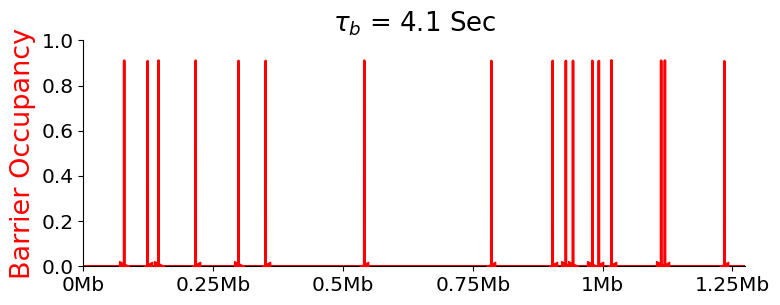

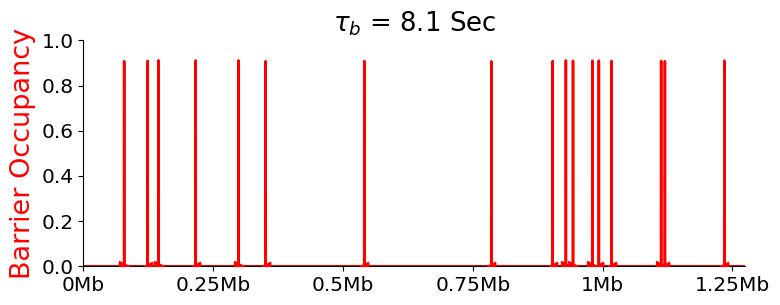

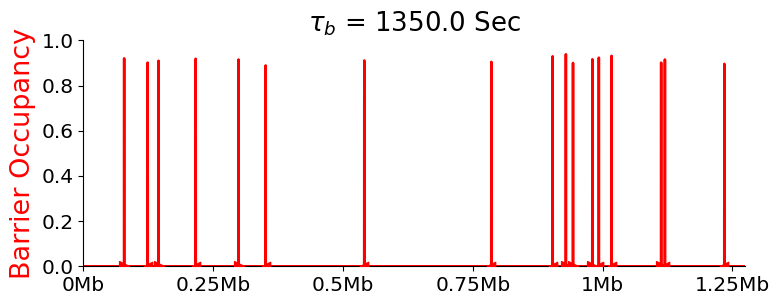

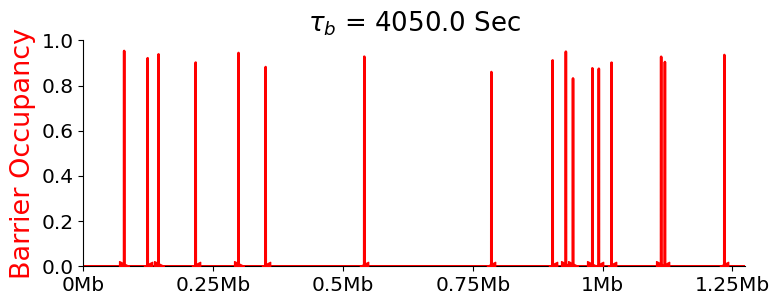

In [8]:
traj = 190000

velocity_range=[1]
lifetime_range = [500]
ctcf_life_range = [  1.5, 3.0, 500, 1500]
ctcf_oftime_range = [0.15, 0.3, 50, 150]
c=1
convertor =60*22.5/500
#trials = 3
#plt.figure(figsize=(17,17))
file = open('../data/loopsize_between_convctcf','w')
file.write('life,vel,clife,cof,loopmean,loopstd\n')
for lifetime_val in lifetime_range:
    for velocity_val in velocity_range:
        for ctcf_life in ctcf_life_range:
            #print('lifetime = %s, velocity = %s, ctcf_life =%s, ctcf_oftime=%s'%(lifetime_val,velocity_val,ctcf_life,ctcf_life/10))
    
            paramdict_CTCF['LEF_lifetime']=[lifetime_val, lifetime_val]
            paramdict_CTCF['velocity_multiplier'] = velocity_val
            paramdict_CTCF['LEF_stalled_lifetime']= [lifetime_val, lifetime_val]
            paramdict_CTCF['CTCF_lifetime']=[ctcf_life, ctcf_life]
            paramdict_CTCF['CTCF_offtime']=[ctcf_life/10, ctcf_life/10]
            
            ctcfrightarys = []
            ctcfleftarys = []
            translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                                 site_types,
                                                 CTCF_left_positions,
                                                 CTCF_right_positions, 
                                                 **paramdict_CTCF)
            for _ in range(traj+1):
                translocator.step()
                ctcfrights = np.array(translocator.stallProbRight)
                ctcflefts = np.array(translocator.stallProbLeft)
                ctcfrightstrue = np.where(ctcfrights)[0]
                ctcfleftstrue = np.where(ctcflefts)[0]
                ctcfrightarys.append(ctcfrightstrue)
                ctcfleftarys.append(ctcfleftstrue)
            ctcfrightary = flattened_array = np.concatenate([arr.flatten() for arr in ctcfrightarys if arr.size > 0])
            ctcfleftary = flattened_array = np.concatenate([arr.flatten() for arr in ctcfleftarys if arr.size > 0])
            ctcfs = list(ctcfrightary)+list(ctcfleftary)
            a, b = np.histogram(ctcfs, np.arange(0,sites_per_replica,1))
            plt.figure(figsize = (7.91,3.15))
            plt.title(r'$\tau_b$ = %.1f Sec'%(ctcf_life*convertor),fontsize=18.75)
            #plt.grid(True)
            plt.ylim(0,1)
            plt.xlim(100, 5100)
            plt.plot(a/traj, color = 'red',linewidth=1.85,alpha = 1)
            plt.scatter(ctcfrightlist,np.zeros(len(ctcfrightlist)),marker='>',color='red',s=50,zorder=3)
            plt.scatter(ctcfleftlist,np.zeros(len(ctcfleftlist)),marker='<',color='red',zorder=3)
            plt.gca().spines['right'].set_visible(False)
            plt.gca().spines['top'].set_visible(False)
            plt.xticks(fontsize=14.5)
            plt.yticks(fontsize = 14.5)
            plt.xticks([0,1000,2000,3000,4000,5000])
            #plt.yticks([0,100,200,300,400,500])
            plt.gca().set_xticklabels(['0Mb', '0.25Mb', '0.5Mb','0.75Mb','1Mb', '1.25Mb'])
            #plt.gca().set_yticklabels(['0Mb', '0.25Mb', '0.5Mb','0.75Mb','1Mb', '1.25Mb'])
            plt.ylabel('Barrier Occupancy',color='red',fontsize=19.5)
            plt.tight_layout()
            plt.savefig('../figs/ctcf_chip_tau_%s.pdf'%ctcf_life,transparent=True)
            plt.show()

In [ ]:
plt.rcParams['pdf.fonttype'] = 42

### chipseq visualization for cohesins

In [9]:
path_dict = {}

directory='/project/fudenber_735/polychrom/Dynamic_boundary_model/1d_sims_dynamic_boundary/dynamical_boundary_simulations/sims/'

for fname  in glob.glob(directory+'folder*'):
    path_dict[fname.split('sims/')[1][:]]= fname
path_dict = dict(sorted(path_dict.items()))

In [10]:
ctcfrightlist = [314, 579, 1195, 3717, 3772, 3921, 4451, 5193, 5723, 6302, 6574, 6779, 7000, 9232, 9310, 9861]
ctcfleftlist = [495, 865, 1404, 2164, 3143, 3615, 3971, 4069, 4480, 4938, 5300, 5587, 6401, 7725, 8764, 9619]
lst = np.array(ctcfrightlist + ctcfleftlist)


In [11]:
### list of boundary elements on all replications

rep = 10 
mon = 1000
site = 10
lst_t = []
for i in range(rep):
    lst_t += list(np.array(lst)+i*mon*site)

In [12]:
def peak_positions(boundary_lst_t, window_sizes=[1]):
    peak_monomers = np.array([])
    for i in window_sizes:
        inds_to_add=[boundary_lst_t[j]+i for j in range(len(boundary_lst_t))]
        peak_monomers = np.hstack((peak_monomers,inds_to_add))
    return peak_monomers.astype(int)

def FRiP(num_sites_t, lef_positions, peak_positions ):
    
    hist,edges = np.histogram(  lef_positions  , np.arange(num_sites_t+1) )
    return np.sum(hist[peak_positions] )/len(lef_positions)

In [13]:
def peak_positions(boundary_list, window_sizes=[1]):
    """
    Calculate peak positions based on a boundary_list within window_sizes.

    Args:
        boundary_list (list): List of boundary values.
        window_sizes (list, optional): List of window sizes. Defaults to [1].

    Returns:
        np.ndarray: Array containing peak positions.
    """
    peak_monomers = np.array([])

    for i in window_sizes:
        inds_to_add = [boundary + i for boundary in boundary_list]
        peak_monomers = np.hstack((peak_monomers, inds_to_add))

    return peak_monomers.astype(int)

folder_face_1.0_back_0_Clife_3.0_Cof_0.3_life_500.0_slife_500.0_birth_0.1_pause_0.9_sep_100_site_10_monomer_1000_replica_10_steps_20.0_vel_1
10000
1000000


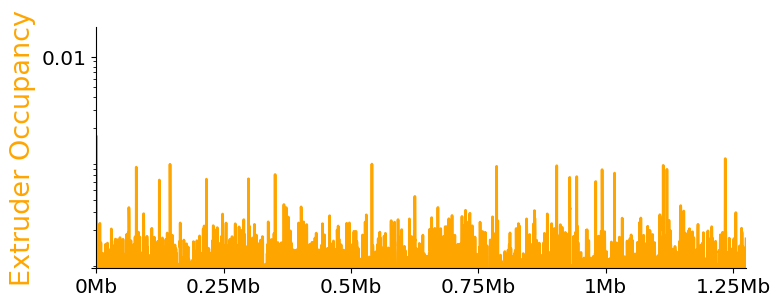

folder_face_1.0_back_0_Clife_500.0_Cof_50.0_life_500.0_slife_500.0_birth_0.1_pause_0.9_sep_100_site_10_monomer_1000_replica_10_steps_20.0_vel_1
10000
1000000


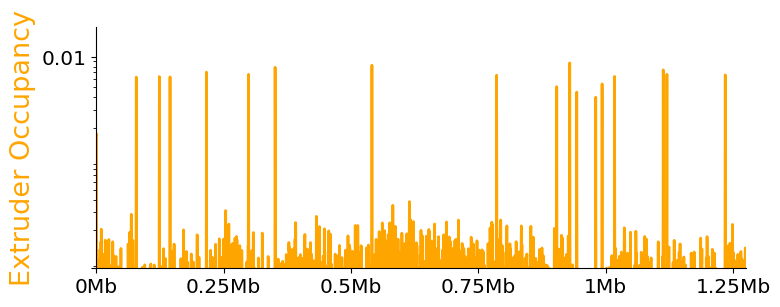

folder_face_1.0_back_0_Clife_1500.0_Cof_150.0_life_500.0_slife_500.0_birth_0.1_pause_0.9_sep_100_site_10_monomer_1000_replica_10_steps_20.0_vel_1
10000
1000000


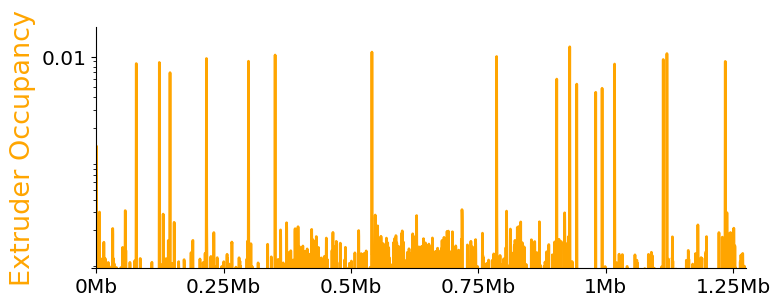

In [17]:
window_size = 1
numx,numy = 1,len(path_dict)
min_time = -500000
c=0
#plt.figure(figsize=(10.5,1.95*len(path_dict)))
hist_dict = {}
#lst = np.arange(0,10001,500)
invs_dict = ['folder_face_1.0_back_0_Clife_3.0_Cof_0.3_life_500.0_slife_500.0_birth_0.1_pause_0.9_sep_100_site_10_monomer_1000_replica_10_steps_20.0_vel_1',
             'folder_face_1.0_back_0_Clife_500.0_Cof_50.0_life_500.0_slife_500.0_birth_0.1_pause_0.9_sep_100_site_10_monomer_1000_replica_10_steps_20.0_vel_1',
            'folder_face_1.0_back_0_Clife_1500.0_Cof_150.0_life_500.0_slife_500.0_birth_0.1_pause_0.9_sep_100_site_10_monomer_1000_replica_10_steps_20.0_vel_1',
            #'folder_face_1.0_back_0_Clife_30.0_Cof_0.3_life_1500.0_slife_1500.0_birth_0.1_pause_0.9_sep_100_site_10_monomer_1000_replica_10_steps_20.0_vel_3'
            ]

for name in invs_dict:
    print(name)
    #print(path_dict[name])
    params=[ast.literal_eval(i) for i in name.split('folder_')[1].split('_')[1::2]]
    face, back, clife, cof, life, slife, birth, pause, sep, site, mon, rep, step, vel = params

    c+=1
    #plt.subplot(numy,numx, c)

    mapN=mon*site
    print(mapN)
    #print(path_dict[name]+'/LEFPositions.h5')
    lefs = h5py.File(path_dict[name]+'/LEFPositions.h5','r')["positions"]
    print(len(lefs))
    
    
    lef_lefts = lefs[min_time:,:,0].flatten()
    lef_rights = lefs[min_time:,:,1].flatten()
    lef_positions = np.hstack((lef_lefts,lef_rights))

    peak_monomers = peak_positions(lst_t,window_sizes=np.arange(-window_size,(window_size)+1) )
    frip = FRiP(mapN * rep, lef_positions, peak_monomers)
    #print(frip)


    plt.figure(figsize = (7.915,3))
    a,b = np.histogram(  np.mod( np.hstack((lef_lefts,lef_rights)) , mapN ), np.arange(0,mapN,1))
    #print(b)
    plt.plot(a[:]/np.sum(a), label=name,color='orange',linewidth=1.95)
    
    #plt.grid(True)
    hist_dict[name] = a/np.sum(a)
    #plt.title(r' $\tau$=%s'%(clife))
    
    plt.yscale('log')
    #plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=True))
    #plt.gca().tick_params(right=False, top=False)
    plt.ylim([0.000085,.0195])
    plt.xlim(100,5100)
    # Hide frame on the right and top axes
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    plt.xticks(fontsize=14.5)
    plt.yticks(fontsize = 14.5)
    plt.xticks([0,1000,2000,3000,4000,5000])
    plt.yticks([0.000085,.01])
    plt.gca().set_xticklabels(['0Mb', '0.25Mb', '0.5Mb','0.75Mb','1Mb', '1.25Mb'])
    plt.gca().set_yticklabels(['','0.01'])
    plt.ylabel('Extruder Occupancy',color='orange',fontsize=19.5)
    plt.tight_layout()
    plt.savefig('../figs/extchipseq_for_%s.pdf'%clife,transparent=True)
    plt.show()
